In [17]:
# Loading of libraries
import numpy as np
import scipy.spatial.distance
import matplotlib.pyplot as plt
from numba import autojit
from numbapro import vectorize, cuda, jit
import time;

%matplotlib inline

In [16]:
# Design variables
AverageRadius            = 1
DeviationRadius          = AverageRadius / 10
ParticleCount            = 500
Viscosity                = 1E3
ViscosityR               = 32 / 3 * Viscosity
RotationalViscoisty      = 1E3
RotationalViscoistyR     = 4 * 3.1415 * RotationalViscoisty
NeighbourDistance        = 2.7 * AverageRadius
SpringConstant           = 1
Chi                      = 1         # Rotational viscosity    - 1 in natural units
Zeta                     = 1         # Translational visocsity - 1 in natural units
k                        = 1         # Sprint constant         - 1 in natural units

# Simulation variables
TimeStep                 = 1
L_align                  = 0.1       # Range from 0.1 to 1
L_noise                   = 0.04      # Range from 0.04 to 0.08
L_F_in                   = 0.3
L_T_in                   = 3
L_self                   = 0.03
T_align                  = L_align * k * Chi / Zeta
T_noise                  = np.sqrt(L_noise / Zeta / TimeStep * 2 * k * Chi**2)
F_in                     = L_F_in * AverageRadius * k
T_in                     = L_T_in * Chi * k / Zeta
F_self                   = L_self * k * AverageRadius

pi                       = 3.1415


# Initiate the pengiuins
Radius                   = np.random.normal(AverageRadius, DeviationRadius, ParticleCount)
Location                 = (np.vstack((
                             np.tile(np.arange(0,10), ParticleCount / 10) * 2,
                             np.repeat(np.arange(0,ParticleCount / 10), 10) * 2
                           ))).T# + np.random.normal(0,1,(ParticleCount,2))
Velocity                 = np.zeros([ParticleCount, 2])
Orientation              = np.ones(ParticleCount) * 3.1415 / 2 + np.random.uniform(-pi/4, pi/4, ParticleCount)
AngularVelocity          = np.zeros(ParticleCount)


In [19]:
#@jit(['float64[:,:](float64[:], int64[:], float64[:], float64[:,:], float64, float64, float64)'])
def ParticleForce(AngleRange, Boundary, Orientation, Overlap, F_self, F_in, k):
    # Particle force = Self-Propulsion + Boundary + Repulsion
    
    Dir =  np.array([np.cos(Orientation), np.sin(Orientation)])
    PropulsionForce = F_self * Dir
    BoundaryForce   = F_in * (AngleRange - pi) * Boundary * Dir
    RepulsionForce  = k * Overlap.T;
    
    return np.transpose(PropulsionForce + BoundaryForce + RepulsionForce)

@jit(['float64[:](float64[:], float64[:], int64[:], float64, float64, float64)'])
def ParticleTorque(Orientation, AvgAngles, Boundary, T_in, T_noise, T_align):
    # Particletorque = Self-Torque + Noise + Align
    deltaTheta = np.mod(Orientation - AvgAngles, 2*np.pi);
    BoundaryTorque = T_in * deltaTheta * Boundary
    NoiseTorque    = T_noise * np.random.uniform(-1,1,Orientation.shape[0])
    AlignTorque    = T_align * deltaTheta;
    
    return BoundaryTorque + NoiseTorque + AlignTorque

## This functions creates a list of neighbours for all particles
#  ParticleLocations is the Nx2 array containing the locations of the particles
def NeighbourList(Location):
    Distances = scipy.spatial.distance.squareform(scipy.spatial.distance.pdist(Location))
    Neighbours = np.nonzero(Distances + np.diag(np.ones(Location.shape[0]) * 3) < 2.7);
    return np.array(Neighbours, dtype='int64').T


def NeighbourRadius(Location, Neighbours):
    Angles = np.arctan2(
        Location[Neighbours[:,0],1] - Location[Neighbours[:,1],1],
        Location[Neighbours[:,0],0] - Location[Neighbours[:,1],0],
    )
    AvgAngle   = np.zeros([Location.shape[0]])
    Boundary   = np.zeros([Location.shape[0]])
    AngleRange = np.zeros([Location.shape[0]])
    for i in range(0, Location.shape[0]):
        N = Neighbours[:,0] == i
        A = np.array(np.nonzero(N)[0])
        if (A.size == 0):
            continue
        AvgAngle[i] = np.sum(Angles[A]) / np.sum(N)
        if (np.max(np.abs(Angles[A] - AvgAngle[i])) < np.pi / 2):
            Boundary[i] = 1
            AngleRange = np.max(Angles[A] - AvgAngle[i]) - np.min(Angles[A] - AvgAngle[i])
        else:
            Boundary[i] = 0
    return AvgAngle, AngleRange, Boundary

@autojit
def NeighbourOverlap(Location, Neighbours, Radius, Overlap):
    for i in range(0,Location.shape[0]):
        Overlap[i,:] = 0;
        N = Neighbours[:,0] == i
        if (N.size == 0):
            Overlap[i,:] = 0
            continue;
        for j in range(N.size):
            if (not N[j] or i == j):
                continue;
            Dir = Location[i,:] - Location[Neighbours[j,1], :]
            d = np.sqrt(np.sum(Dir**2))
            r = Radius[Neighbours[j,1]]
            R = Radius[i]
            c = 2*d*r - d**2
            if (c < 0):
                continue;
            A = ((r+R)-d) * (2*np.sqrt(c)) / 2;
            Overlap[i,:] += A / d * Dir

In [20]:
max_steps = np.int(1E4);
#max_steps = 0;

Torque    = np.zeros([Location.shape[0]])
Force     = np.zeros([Location.shape[0],2])
Overlap   = np.zeros([Location.shape[0],2])


start = time.clock();
for step in range(0,max_steps):
    if (step%100 == 0):
        print(step)
    
    Neighbours                       = NeighbourList(Location)
    Boundary, AvgAngles, AngleRange  = NeighbourRadius(Location, Neighbours)
    NeighbourOverlap(Location, Neighbours, Radius, Overlap)
    
    Torque[:]          = ParticleTorque(Orientation, AvgAngles, Boundary, T_in, T_noise, T_align)
    AngularVelocity[:] = Torque / (Chi * Radius*Radius)
    Orientation[:]     = Orientation[:] + TimeStep * AngularVelocity
    
    
    Force[:,:]         = ParticleForce(AngleRange, Boundary, Orientation, Overlap, F_self, F_in, k)
    Velocity[:,:]      = np.divide(Force, np.stack((Zeta * Radius,Zeta * Radius)).T)
    Location[:,:]      = Location[:,:] + TimeStep * Velocity
    
print(time.clock() - start);

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500
2600
2700
2800
2900
3000
3100
3200
3300
3400
3500
3600
3700
3800
3900
4000
4100
4200
4300
4400
4500
4600
4700
4800
4900
5000
5100
5200
5300
5400
5500
5600
5700
5800
5900
6000
6100
6200
6300
6400
6500
6600
6700
6800
6900
7000
7100
7200
7300
7400
7500
7600
7700
7800
7900
8000
8100
8200
8300
8400
8500
8600
8700
8800
8900
9000
9100
9200
9300
9400
9500
9600
9700
9800
9900
60.90750222222232


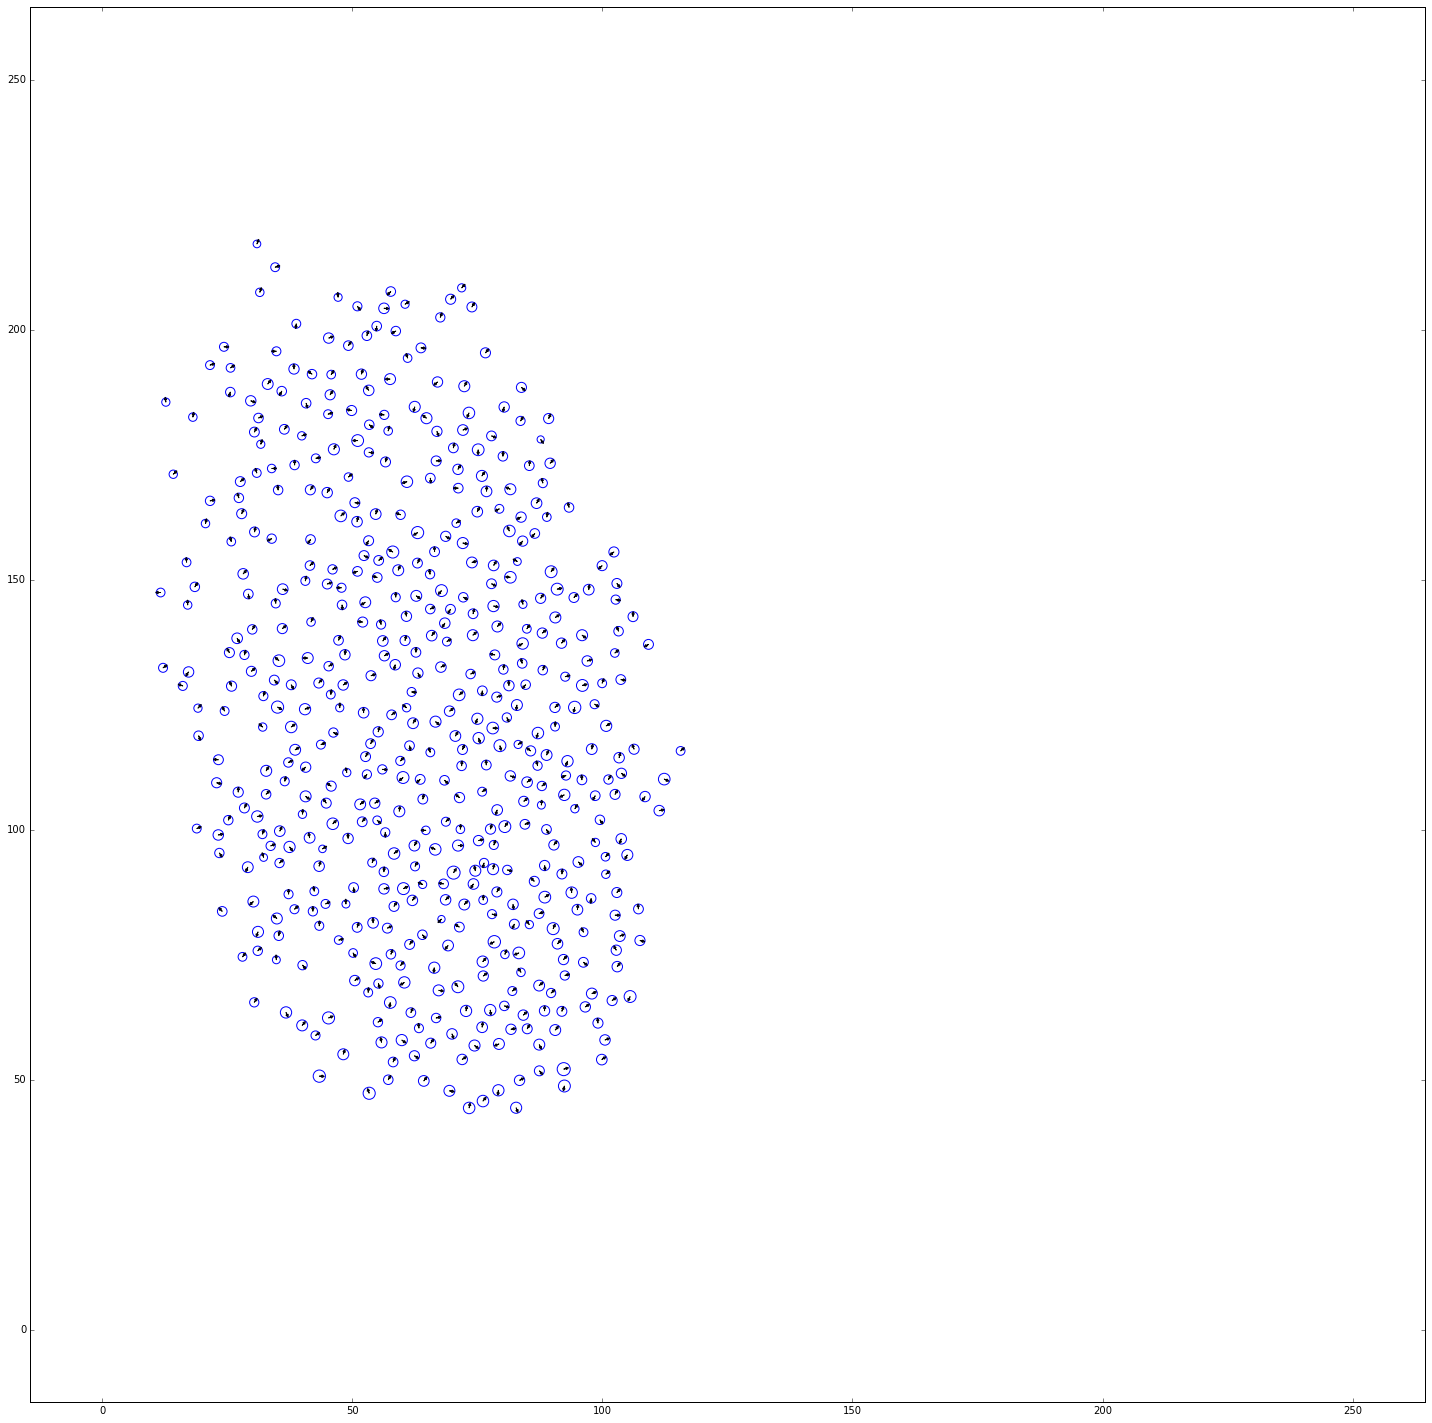

In [10]:
## Visulaization
fig = plt.figure();
plt.rcParams['figure.figsize'] = (25,25)
ax = plt.gca();
for i in range(Location.shape[0]):
    circle = plt.Circle((Location[i,0], Location[i,1]), Radius[i], color='b', fill=False)
    ax.add_artist(circle);
    ax.arrow(
        Location[i,0],
        Location[i,1],
        0.5 * np.cos(Orientation[i]),
        0.5 * np.sin(Orientation[i]),
        head_width = 0.5,
        head_length = 0.5
    )
a = 1.5;
xd = np.mean(Location[:,0]) - np.abs(np.mean(Location[:,0]) - np.min(Location[:,0])) * a
xu = np.mean(Location[:,0]) + np.abs(np.mean(Location[:,0]) - np.max(Location[:,0])) * a
yd = np.mean(Location[:,1]) - np.abs(np.mean(Location[:,1]) - np.min(Location[:,1])) * a
yu = np.mean(Location[:,1]) + np.abs(np.mean(Location[:,1]) - np.max(Location[:,1])) * a

xu = max(xu, yu);
xd = min(xd, yd);
ax.set_xlim(xd, xu)
ax.set_ylim(xd, xu)
plt.show()

In [11]:
print(np.mean(np.abs(Velocity)))

0.0226782116704
